- Agile Methodology
    * 


- Prepare elevator pitch for standup meetings


Kanban Board Format (use trello):

| icebox | todo | doing | done |
|--------|------|-------|------|


* submit github link and trello link by monday
* submit first simple model by wednesday
* submit MVP by 11/29
* any deployments (flask) must be submitted by 12/1
* code freeze and practice presentations on 12/2
* second practice presentations on 12/6
* presenting on 12/8

In [1]:
import pandas as pd
import numpy as np
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, mean_squared_log_error

from statsmodels.formula.api import ols

from scipy import stats

In [2]:
df_meta = pd.read_csv('/Users/evanjays/Desktop/Programming/Flatiron/CAPSTONE/data_big/ashrae-energy-prediction/building_metadata.csv')
df = pd.read_csv('/Users/evanjays/Desktop/Programming/Flatiron/CAPSTONE/data_big/ashrae-energy-prediction/train.csv')
df_weather = pd.read_csv('/Users/evanjays/Desktop/Programming/Flatiron/CAPSTONE/data_big/ashrae-energy-prediction/weather_train.csv')
df_sample = pd.read_csv('/Users/evanjays/Desktop/Programming/Flatiron/CAPSTONE/data_big/ashrae-energy-prediction/sample_submission.csv')

In [3]:
df_weather['timestamp'] = pd.to_datetime(df_weather['timestamp'])
df_weather_time = df_weather.copy(deep=True)

df_weather_time.set_index('timestamp',drop=True,inplace=True)

<AxesSubplot:xlabel='timestamp'>

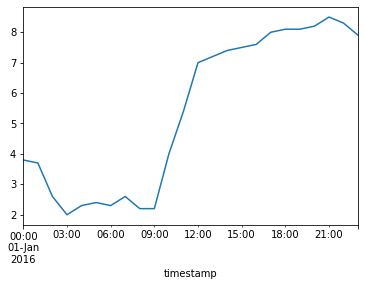

In [85]:
df_weather_time[df_weather_time['site_id'] == 1]['air_temperature'][:24].plot()

In [86]:
df_weather_time.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 139773 entries, 2016-01-01 00:00:00 to 2016-12-31 23:00:00
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   site_id             139773 non-null  int64  
 1   air_temperature     139718 non-null  float64
 2   cloud_coverage      70600 non-null   float64
 3   dew_temperature     139660 non-null  float64
 4   precip_depth_1_hr   89484 non-null   float64
 5   sea_level_pressure  129155 non-null  float64
 6   wind_direction      133505 non-null  float64
 7   wind_speed          139469 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 9.6 MB


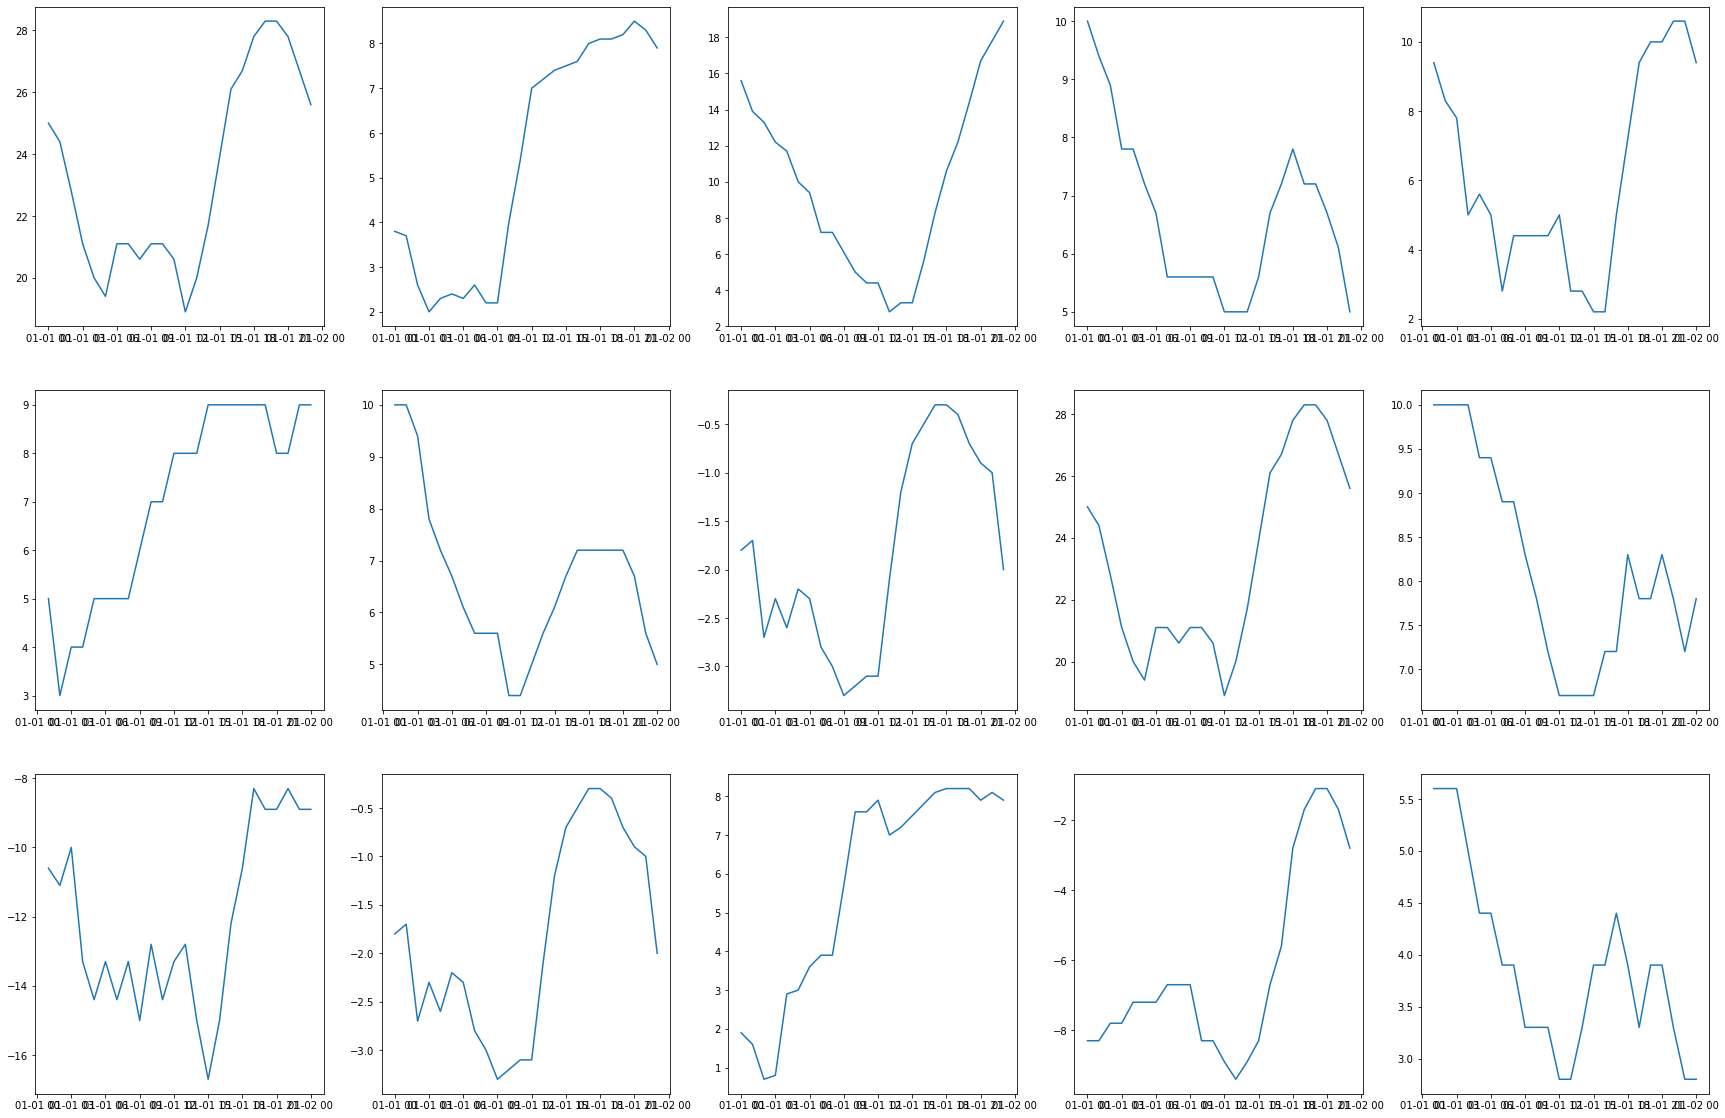

In [87]:
fig, ax = plt.subplots(ncols=5,nrows=3,figsize=(30,20))
count = 0
for i in range(3):
    for j in range(5):
        ax[i,j].plot(df_weather_time[df_weather_time['site_id'] == count]['air_temperature'][:24])
        count += 1

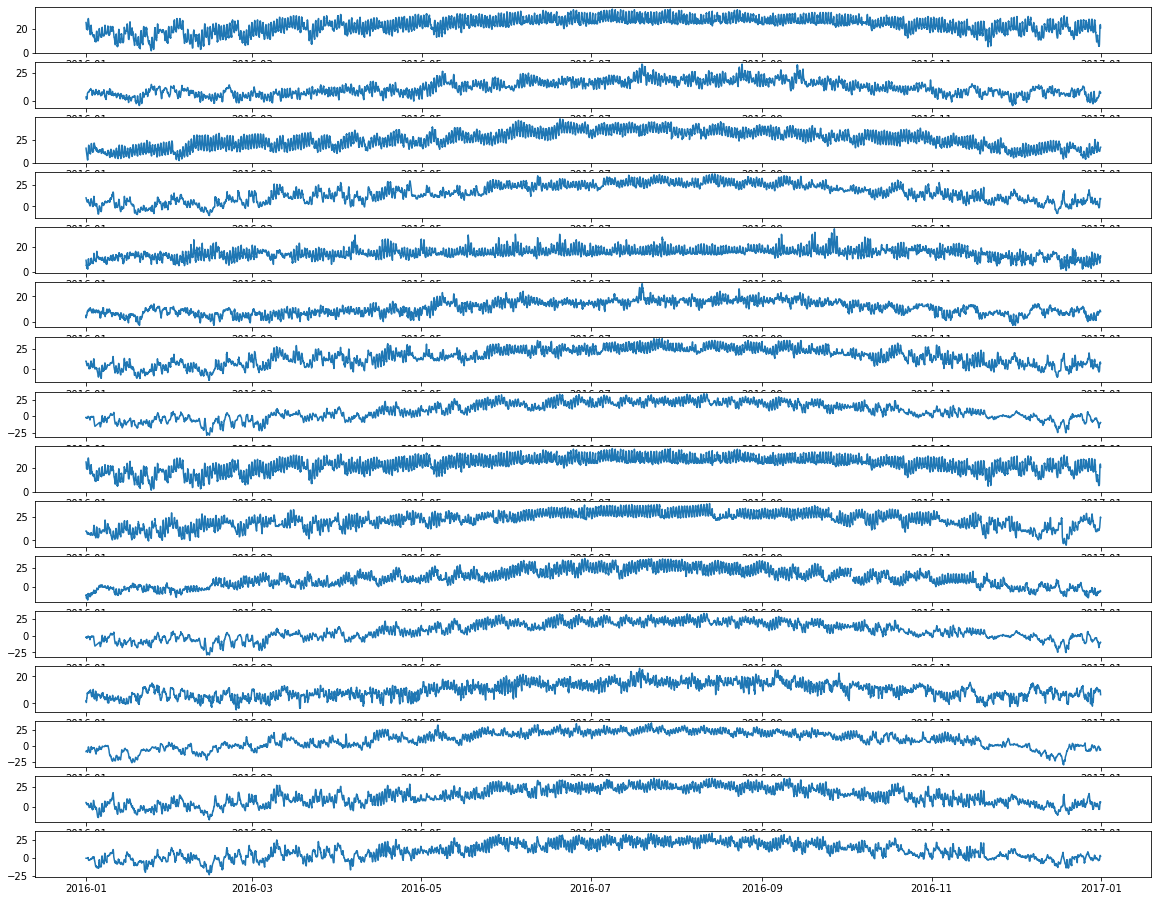

In [88]:
fig, axes = plt.subplots(nrows=16,figsize=(20,16))
for i in range(16):
    df_weather_temp = df_weather_time[df_weather_time['site_id'] == i]
    axes[i].plot(df_weather_temp['air_temperature'])

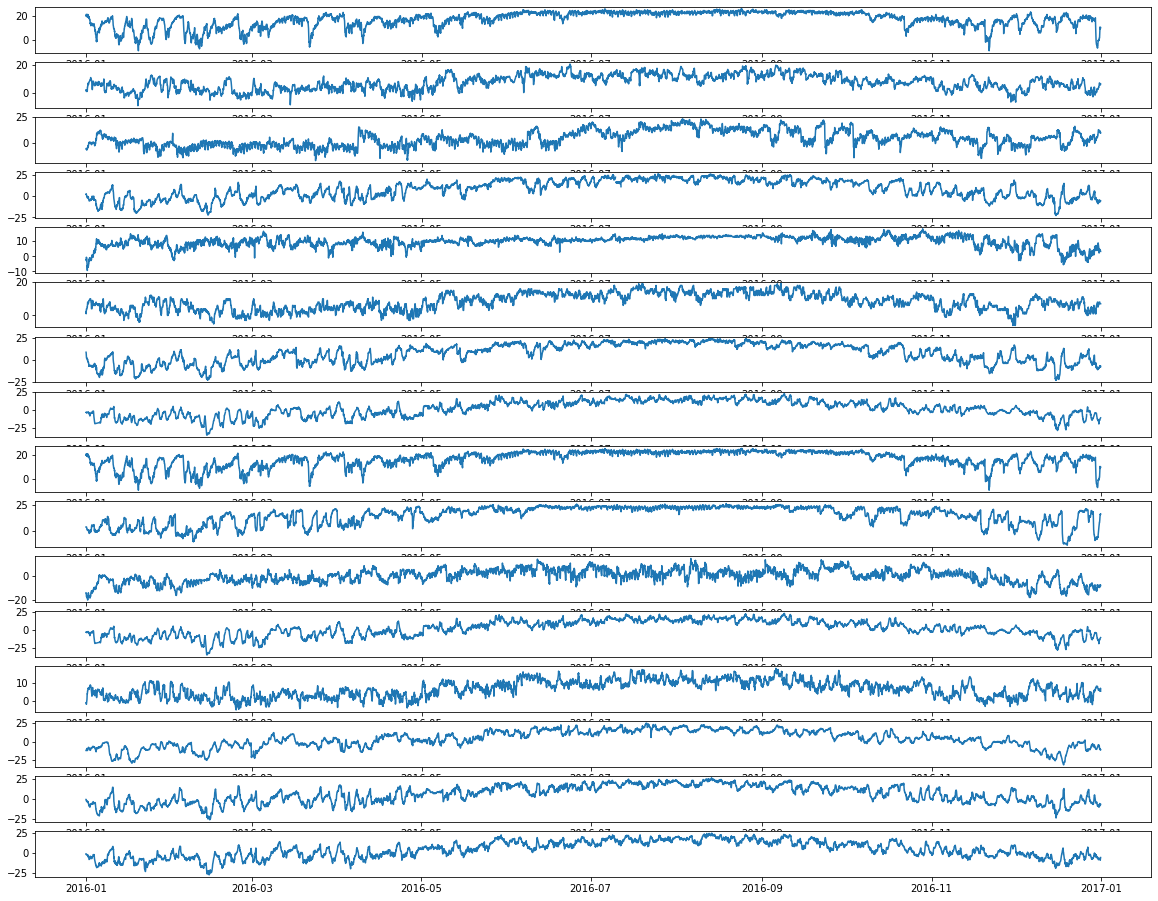

In [89]:
fig, axes = plt.subplots(nrows=16,figsize=(20,16))
for i in range(16):
    df_weather_temp = df_weather_time[df_weather_time['site_id'] == i]
    axes[i].plot(df_weather_temp['dew_temperature'])

### Preprocessing Weather Data

In [12]:
df_weather_time[df_weather_time.site_id == 1].shape

(8763, 8)

In [29]:
df_weekday = pd.DataFrame(([1]*24+[0]*24+[0]*24+[1]*24+[1]*24+[1]*24+[1]*24)*52+[1]*24,columns=['is_weekday'])
df_weekday.shape

(8760, 1)

In [37]:
df_weather_time[df_weather_time.site_id == 15].head(24)

,site_id,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
timestamp,,,,,,,,
2016-01-01 01:00:00,15,-1.0,NaN,-1.0,NaN,NaN,330.0,4.1
2016-01-01 02:00:00,15,-1.0,NaN,-1.0,NaN,NaN,330.0,2.6
2016-01-01 03:00:00,15,-1.0,NaN,-2.0,NaN,NaN,340.0,2.1
2016-01-01 12:00:00,15,-1.0,NaN,-3.0,NaN,NaN,250.0,2.6
2016-01-01 13:00:00,15,-1.0,NaN,-3.0,NaN,NaN,240.0,3.1
2016-01-01 14:00:00,15,-1.0,NaN,-2.0,NaN,NaN,240.0,4.1
2016-01-01 15:00:00,15,-1.0,NaN,-2.0,NaN,NaN,240.0,4.6
2016-01-01 16:00:00,15,-1.0,NaN,-3.0,NaN,NaN,270.0,5.1
2016-01-01 17:00:00,15,-1.0,NaN,-4.0,NaN,NaN,240.0,7.2


<AxesSubplot:xlabel='timestamp'>

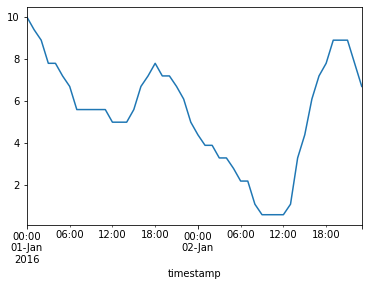

In [36]:
df_weather_time[df_weather_time['site_id'] == 3]['air_temperature'][:48].plot()

<AxesSubplot:xlabel='timestamp'>

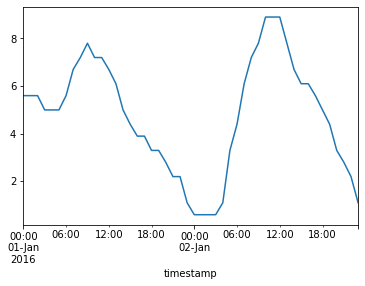

In [35]:
df_temp_x[df_temp_x['site_id'] == 3]['air_temperature'][:48].plot()

In [50]:
def time_shift(dataframe,site):
    time_shift_dict = {0:-3,1:-5,2:-7,3:-9,4:-7,5:0,6:-12,7:-3,8:-4,9:-10,10:-3,11:-3,12:-16,13:-5,14:-12,15:-5}
    df_temp_1 = pd.DataFrame()
    df_temp_1 = dataframe.shift(periods=time_shift_dict[site],freq='H')
    df_temp_1 = df_temp_1[(df_temp_1.index > '2015-12-31 23:00:00') & (df_temp_1.index < '2016-12-31')]
    df_temp_1['site_id'].interpolate(inplace=True)
    df_temp_1['air_temperature'].interpolate(inplace=True)
    return df_temp_1

In [54]:
def time_shift_tz(dataframe,site):
    time_shift_dict = {0:'EST',1:'Europe/London',2:'America/Phoenix',3:'EST',4:'US/Pacific',5:'Europe/London',6:'EST',7:'America/Montreal',8:'EST',9:'Canada/Mountain',10:'US/Pacific',11:'America/Montreal',12:'GMT',13:'America/Mexico_City',14:'EST',15:'EST'}
    df_temp_1 = dataframe.tz_localize(time_shift_dict[site])
    df_temp_1 = df_temp_1.tz_convert('UTC')
    return df_temp_1

In [56]:
df_temp_x = time_shift_tz(df_weather_time[df_weather_time.site_id == 3],3)
# df_temp_x.reset_index(inplace=True)

# df_temp_x = pd.concat([df_temp_x,df_weekday],axis=1)

df_temp_x.head()

,site_id,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
timestamp,,,,,,,,
2016-01-01 05:00:00+00:00,3,10.0,8.0,2.2,NaN,1021.1,350.0,4.1
2016-01-01 06:00:00+00:00,3,9.4,NaN,2.8,0.0,1021.5,350.0,6.2
2016-01-01 07:00:00+00:00,3,8.9,NaN,2.2,0.0,1021.7,10.0,4.6
2016-01-01 08:00:00+00:00,3,7.8,8.0,1.1,0.0,1021.7,350.0,7.7
2016-01-01 09:00:00+00:00,3,7.8,NaN,0.6,0.0,1021.8,340.0,4.1


In [17]:
# Create Weather input variables sampled daily
site_weather_list = []
# df_weekday = pd.DataFrame([1,0,0,1,1,1,1] * 52 + [1,0],columns=['is_weekday'])   #DAILY
df_weekday = pd.DataFrame(([1]*24+[0]*24+[0]*24+[1]*24+[1]*24+[1]*24+[1]*24)*52+[1]*24+[0]*3,columns=['is_weekday'])

for i in range(16):
    df_temp = pd.DataFrame()
    df_temp = df_weather_time[df_weather_time['site_id'] == i]
    df_temp = time_shift(df_temp,i)
    df_temp.reset_index(inplace=True)
    df_temp = pd.concat([df_temp,df_weekday],axis=1)
    site_weather_list.append(df_temp)

df_weather_bm = pd.DataFrame()
for dataframe in site_weather_list:
    dataframe.reset_index(inplace=True,drop=True)
    df_weather_bm = pd.concat([df_weather_bm,dataframe])

si = SimpleImputer()

df_weather_bm['cloud_coverage'] = si.fit_transform(df_weather_bm[['cloud_coverage']])
df_weather_bm['dew_temperature'] = si.fit_transform(df_weather_bm[['dew_temperature']])
df_weather_bm['sea_level_pressure'] = si.fit_transform(df_weather_bm[['sea_level_pressure']])
df_weather_bm['precip_depth_1_hr'] = si.fit_transform(df_weather_bm[['precip_depth_1_hr']])
df_weather_bm['wind_direction'] = si.fit_transform(df_weather_bm[['wind_direction']])
df_weather_bm['wind_speed'] = si.fit_transform(df_weather_bm[['wind_speed']])

In [21]:
site_weather_list[15]

,timestamp,site_id,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,is_weekday
0,2016-01-01 01:00:00,15.0,-1.0,NaN,-2.0,NaN,NaN,240.0,4.1,1
1,2016-01-01 02:00:00,15.0,-1.0,NaN,-2.0,NaN,NaN,240.0,4.6,1
2,2016-01-01 03:00:00,15.0,-1.0,NaN,-3.0,NaN,NaN,270.0,5.1,1
3,2016-01-01 12:00:00,15.0,-1.0,NaN,-4.0,NaN,NaN,240.0,7.2,1
4,2016-01-01 13:00:00,15.0,-1.0,NaN,-4.0,NaN,NaN,240.0,7.2,1
...,...,...,...,...,...,...,...,...,...,...
8758,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
8759,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
8760,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
8761,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


### Preprocessing Building Metadata

In [92]:
use_dict = {}
for use in df_meta['primary_use'].unique():
    if df_meta[df_meta['primary_use'] == use]['floor_count'].isna().sum() == df_meta[df_meta['primary_use'] == use]['floor_count'].shape[0]:
        use_dict[use] = 1
    else:
        use_dict[use] = round(df_meta[df_meta['primary_use'] == use]['floor_count'].median())

def impute_num_floors(num_floors):
    if num_floors > 0:
        return num_floors
    else:
        return use_dict[use]

metadata_list = []
for idx,use in enumerate(df_meta['primary_use'].unique()):
    df_temp = pd.DataFrame()
    df_temp = df_meta[df_meta['primary_use'] == use].copy(deep=True)
    df_temp['floor_count'] = df_temp['floor_count'].map(impute_num_floors)
    metadata_list.append(df_temp.copy(deep=True))

df_meta_imputed = pd.DataFrame()
for dataframe in metadata_list:
    df_meta_imputed = pd.concat([df_meta_imputed,dataframe])

df_meta_imputed.drop(['year_built'],inplace=True,axis=1)

### Merging Metadata with Weather Data

In [93]:
df_meta_weather = df_meta_imputed.merge(df_weather_bm,how='right',on='site_id')

### Resampling Meter Reading Data

In [94]:
meter_data_list = []
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df[df['meter'] == 0]
for i in df['building_id'].unique():
    df_temp = pd.DataFrame()
    df_temp = df[df['building_id'] == i].copy(deep=True)
    df_temp.set_index('timestamp',inplace=True)
    df_temp = df_temp.groupby('building_id').resample('D').sum()
    meter_data_list.append(df_temp)

df_meter_bm = pd.DataFrame()
for dataframe in meter_data_list:
    dataframe.drop(['building_id'],inplace=True,axis=1)
    dataframe.reset_index(inplace=True) 
    df_meter_bm = pd.concat([df_meter_bm,dataframe])

### Merging Meter Reading Data with main Dataframe

In [95]:
df_final = df_meter_bm.merge(df_meta_weather,how='left',on=['building_id','timestamp'])
df_final.drop(['meter'],axis=1,inplace=True)
df_final = df_final[df_final['meter_reading'] > 0]

In [96]:
# Dropping Outliers
df_final = df_final[(np.abs(stats.zscore(df_final['meter_reading'])) < 3)]

In [97]:
df_final.describe()

,building_id,meter_reading,site_id,square_feet,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,is_weekday
count,476945.000000,476945.000000,476945.000000,476945.000000,476945.000000,476945.000000,476945.000000,476945.000000,476945.000000,476945.000000,476945.000000,476945.000000,476945.000000
mean,722.873239,3391.447004,6.914697,87170.138261,3.146036,15.859094,2.695987,8.147020,1.071586,1016.319763,174.531722,3.561367,0.713399
std,407.131323,4719.497987,4.894557,99575.012539,2.218966,9.918315,2.310794,9.640054,3.056724,6.488860,71.204479,1.639711,0.452174
min,0.000000,0.009400,0.000000,283.000000,1.000000,-24.495833,0.000000,-30.054167,-1.000000,973.327273,1.111111,0.378261,0.000000
25%,370.000000,565.847000,3.000000,22334.000000,1.000000,9.133333,0.750000,1.270833,0.000000,1012.508333,120.000000,2.391667,0.000000
50%,709.000000,1635.981000,5.000000,57189.000000,2.000000,16.505000,2.400811,9.041667,0.000000,1016.144075,170.416667,3.291667,1.000000
75%,1071.000000,4008.000000,13.000000,111623.000000,4.000000,23.571429,4.000000,15.504167,1.661076,1020.116667,231.739130,4.441667,1.000000
max,1448.000000,31204.000000,15.000000,875000.000000,26.000000,39.958333,9.000000,24.504167,134.000000,1044.450000,345.833333,13.625000,1.000000


In [98]:
test_df = pd.DataFrame()
train_df = pd.DataFrame()
for i in range(1449):
    if i % 5 == 0:
        test_df = pd.concat([test_df,df_final[df_final['building_id'] == i]])
    else:
        train_df = pd.concat([train_df,df_final[df_final['building_id'] == i]])

In [99]:
# Taking log of target to keep from predicting negative values for energy usage

y_train = train_df['meter_reading'].copy(deep=True).map(np.log1p)
X_train = train_df.drop(['meter_reading','building_id','timestamp'],axis=1)

y_test = test_df['meter_reading'].copy(deep=True).map(np.log1p)
X_test = test_df.drop(['meter_reading','building_id','timestamp'],axis=1)

In [100]:
X_train

,site_id,primary_use,square_feet,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,is_weekday
367,0,Education,2720,4.0,18.733333,6.400000,14.612500,-0.041667,1018.941667,130.833333,4.154167,0
370,0,Education,2720,4.0,14.433333,2.000000,7.666667,0.000000,1023.133333,143.333333,6.287500,1
374,0,Education,2720,4.0,17.479167,8.111111,16.208333,2.375000,1011.904167,95.000000,1.987500,0
375,0,Education,2720,4.0,18.558333,6.500000,15.391667,-0.041667,1012.970833,249.583333,4.370833,0
377,0,Education,2720,4.0,10.950000,2.842105,0.770833,0.000000,1022.208333,301.666667,3.058333,1
...,...,...,...,...,...,...,...,...,...,...,...,...
507064,15,Office,92271,2.0,3.575000,3.500000,0.016667,2.600000,1012.237500,247.083333,5.229167,1
507065,15,Office,92271,2.0,-2.208696,2.000000,-5.543478,1.500000,1019.230435,221.304348,3.552174,1
507066,15,Office,92271,2.0,-0.445833,0.000000,-3.220833,-0.166667,1005.408333,193.750000,4.912500,1
507067,15,Office,92271,2.0,-1.895833,2.400811,-5.208333,-1.000000,1005.308333,273.333333,6.412500,1


In [101]:
ohe = OneHotEncoder(drop='first')

ohe_train_array = ohe.fit_transform(X_train[['primary_use']])
ohe_train_df = pd.DataFrame(ohe_train_array.todense(),columns=[name[3:] for name in ohe.get_feature_names()])

ohe_test_array = ohe.transform(X_test[['primary_use']])
ohe_test_df = pd.DataFrame(ohe_test_array.todense(),columns=[name[3:] for name in ohe.get_feature_names()])

X_train.reset_index(inplace=True,drop=True)
X_train_ohe = pd.concat([X_train,ohe_train_df],axis=1)
X_train_ohe.drop(['primary_use'],axis=1,inplace=True)

X_test.reset_index(inplace=True,drop=True)
X_test_ohe = pd.concat([X_test,ohe_test_df],axis=1)
X_test_ohe.drop(['primary_use'],axis=1,inplace=True)

In [102]:
column_names = [x.replace(' ','_').replace('/','_') for x in X_train_ohe.columns]

In [103]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train_ohe)
X_train_scaled = pd.DataFrame(X_train_scaled,columns=column_names)

X_test_scaled = ss.transform(X_test_ohe)
X_test_scaled = pd.DataFrame(X_test_scaled,columns=column_names)

<AxesSubplot:>

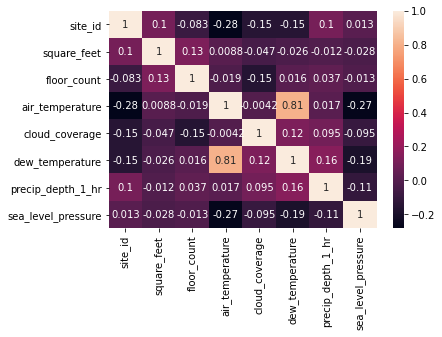

In [104]:
sns.heatmap(X_train_ohe.iloc[:,:8].corr(),annot=True)

In [105]:
lr = LinearRegression()

lr.fit(X_train_scaled,y_train)

cross_val_score(lr,X_train_scaled,y_train)

lr.score(X_test_scaled,y_test)

0.38287092646568166

In [111]:
rfe = RFE(lr,n_features_to_select=15)

rfe.fit(X_train_scaled,y_train)

keep_list = [(k,v) for k,v in zip(X_train_scaled.columns,rfe.support_)]
keep_string = ''
for k,v in keep_list:
    if v:
        keep_string += k + '+'
keep_string = keep_string[:-1]
keep_string

'site_id+square_feet+floor_count+air_temperature+cloud_coverage+dew_temperature+wind_speed+is_weekday+Entertainment_public_assembly+Healthcare+Lodging_residential+Office+Other+Parking+Religious_worship'

In [112]:
X_train_scaled.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)
X_train_final = pd.concat([X_train_scaled,y_train],axis=1)

X_test_scaled.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)
X_test_final = pd.concat([X_test_scaled,y_test],axis=1)

In [113]:
formula = f'meter_reading ~ {keep_string}'
model = ols(formula,X_train_final).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          meter_reading   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.402
Method:                 Least Squares   F-statistic:                 1.712e+04
Date:                Tue, 23 Nov 2021   Prob (F-statistic):               0.00
Time:                        12:35:26   Log-Likelihood:            -6.1076e+05
No. Observations:              381909   AIC:                         1.222e+06
Df Residuals:                  381893   BIC:                         1.222e+06
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         7.2437      0.002   3737.955      0.000       7.240       7.247
site_id                           0.1451      0.002     66.268      0.000       0.141       0.149
square_feet                       0.7962      0.002    386.439      0.000       0.792       0.800
floor_count                       0.4165      0.003    152.631      0.000       0.411       0.422
air_temperature                   0.2530      0.004     70.340      0.000       0.246       0.260
cloud_coverage                    0.1164      0.002     55.327      0.000       0.112       0.121
dew_temperature                  -0.1985      0.003    -57.246      0.000      -0.205      -0.192
wind_speed                       -0.0853      0.002    -41.694      0.000      -0.089      -0.081
is_weekday                        0.0802      0.002     41.383      0.000       0.076       0.084
Entertainment_public_assembly    -0.0971      0.002    -44.544      0.000      -0.101      -0.093
Healthcare                        0.1159      0.002     58.425      0.000       0.112       0.120
Lodging_residential              -0.2428      0.002   -100.984      0.000      -0.248      -0.238
Office                            0.0859      0.002     40.422      0.000       0.082       0.090
Other                            -0.0936      0.002    -47.063      0.000      -0.098      -0.090
Parking                          -0.1938      0.002    -95.897      0.000      -0.198      -0.190
Religious_worship                -0.1064      0.002    -54.649      0.000      -0.110      -0.103
==============================================================================
Omnibus:                    88178.978   Durbin-Watson:                   0.089
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           335890.856
Skew:                          -1.118   Prob(JB):                         0.00
Kurtosis:                       7.014   Cond. No.                         3.61
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [109]:
y_test.describe()

count    95036.000000
mean         7.212661
std          1.559062
min          0.009356
25%          6.413877
50%          7.327301
75%          8.251884
max         10.348014
Name: meter_reading, dtype: float64

In [110]:
y_test_preds = lr.predict(X_test_scaled)
np.sqrt(mean_squared_error(y_test,y_test_preds))
np.sqrt(mean_squared_log_error(y_test,y_test_preds))

0.2154350025532549